In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from  evaluation.core import State
from typing import Dict, List
import datetime
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
from copy import deepcopy
import random
from Rushi.PPO.trainer import PPOTrainer
from Rushi.PPO.ml import PPOAgent
from Rushi.PPO.core import EarlyEnvironment, EarlyEnvs
from Rushi.PPO.utils import Logger, makeFeatures, getInvalidActionMask, getStateFeatures, getStockFeatures, interpolatorNotForDay
from evaluation.core import BaseStrategy
from evaluation.constants import HOLD_ACTION,BUY_ACTION,SELL_ACTION
from Rushi.PPO.constants import MAX_HOLDING, MAX_TRADE_TIME_IN_5_MINUTE, MAX_TRADE_TIME_IN_DAYS, MAX_TRADE_TIME_IN_MINUTE, MODES, minutes_5_in_day, minutes_in_day, ROLLING_WINDOW_SIZE_IN_MINUTE, ROLLING_WINDOW_SIZE_IN_5_MINUTE,end_time_5_minute, end_time_minute
from Rushi.PPO.constants import end_time_minute, end_time_5_minute
from Rushi.PPO.ppoStrategy import PPOStrategy
from evaluation.backTest import BackTest
from tqdm import tqdm

In [2]:
df = pd.read_csv("data/5minute/APOLLOHOSP.csv")
df = interpolatorNotForDay(df= df, mode= "5minute")

total values interpolated = 1230


In [3]:
trainer = None
back_test = None
curr_agent = None
def trainSingleRoll(roll : int,agent : PPOAgent,early_envs : EarlyEnvs,ppo_config,device,num_updates):
    global trainer
    agent.to(device).train()
    logger = Logger(name= "STONK_ROLL_{}".format(roll))
    logger.default_step_size = 1000
    trainer = PPOTrainer(envs= early_envs, agent= agent, ppo_config= ppo_config, device= device, logger= logger)
    trainer.train(num_updates= num_updates, lr= 3e-4)



def evalSingleRoll(roll : int,df, mode,agent : PPOAgent,device, test_start_index, test_end_index):
    global back_test
    ppo_strategy = PPOStrategy(df= df,mode= mode, agent= agent, device= device)
    back_test = BackTest(data= df, strategy= ppo_strategy, initial_cash= 100000, commision= .1, mode= "multi", short= False)
    limits = [test_start_index,test_end_index]
    back_test.runStrategy(limits= limits)
    trades = sum(back_test.log["is_trade_complete"])
    print("num_trades =  {}".format(trades))
    #agent.save(path= "Rushi/long_models2/agent_roll_{}.pt".format(roll))
    return back_test.cash - back_test.initial_cash




def rollingTrain(ppo_config,df,mode,train_days,test_days,device,num_updates = 1000,agent = None):
    global curr_agent
    assert mode in MODES
    unit = None
    if mode == "5minute":
        unit = minutes_5_in_day
    elif(mode == "minute"):
        unit = minutes_in_day
    else:
        unit = 1

    #if agent == None:


    train_start_index,train_end_index = 0,train_days*unit - 1
    test_start_index, test_end_index = train_days*unit, train_days*unit + test_days*unit  - 1
    roll = 1
    profit = 0
    agent = PPOAgent(lstm_hidden_size= 128,lstm_input_size= ppo_config["observation_dim"], layers= 2, output_dim= ppo_config["action_space_dim"])
    agent.to(device=device)
    curr_agent = agent

    reset_update = 8000
    reset = True
    while test_end_index <= len(df):
        agent_path = "Rushi/models2/agent_roll_{}.pt".format(roll)
        if os.path.exists(path= agent_path):
            agent.load(agent_path)
            agent.to(device=device)

        else:
            envs = []
            linspace = [1,1]
            if reset == False:
                linspace = [1,4]
            for _ in range(ppo_config["num_envs"]):
                envs.append(EarlyEnvironment(df = df.iloc[train_start_index:train_end_index + 1], mode= mode,linspace= linspace))
            early_envs = EarlyEnvs(early_environments= envs)
            trainSingleRoll(roll= roll, agent= agent,early_envs= early_envs,device= device,
                            ppo_config= ppo_config,num_updates= num_updates if reset == False else reset_update)
    
        
        roll_profit = evalSingleRoll(roll= roll, mode= mode,agent= agent,device= device,df= df,
                       test_start_index= test_start_index, test_end_index= test_end_index)
        
        if roll_profit < 0:
            print("resetting")
            agent = PPOAgent(lstm_hidden_size= 128,lstm_input_size= ppo_config["observation_dim"], layers= 2, output_dim= ppo_config["action_space_dim"])
            reset = True
        else:
            reset = False
        
        profit += roll_profit

        
        print("total profit= {}".format(profit))
        print("="*30)
        roll += 1
        train_start_index += test_days*unit
        train_end_index += test_days*unit
        test_start_index += test_days*unit
        test_end_index += test_days*unit
        
        

        

    print(profit)


In [4]:
train_days = 300
test_days = MAX_TRADE_TIME_IN_DAYS
ppo_config = dict(
    num_envs = 128,
    num_steps = 256,
    observation_dim = 17,
    action_space_dim = 3,
    gamma = .9,
    num_mini_batches = 4,
    update_epochs = 4,
    clip_coef = .2,
    entropy_coef = .03,
    value_coef = .5,
    max_grad_norm = .5
)

#agent = PPOAgent(lstm_hidden_size= 256,lstm_input_size= ppo_config["observation_dim"], layers= 1, output_dim= ppo_config["action_space_dim"])
#agent.load("Rushi/models/agent1.pt")

In [5]:
rollingTrain(ppo_config= ppo_config, df= df, mode= "5minute", train_days= train_days, test_days= test_days,device= device,num_updates= 10)

STONK_ROLL_1 ---- 1 metric avg_reward = 0.0
STONK_ROLL_1 ---- 1 metric avg_length = 0.0
STONK_ROLL_1 ---- 1 metric avg_profit = 0.0
STONK_ROLL_1 ---- 1 metric avg_trades = 0.0


KeyboardInterrupt: 

In [6]:
env = EarlyEnvironment(df= df.iloc[: ROLLING_WINDOW_SIZE_IN_5_MINUTE  + MAX_TRADE_TIME_IN_5_MINUTE], commision= .1, linspace= [1,1],mode= "5minute")
env.reset()
env.step(action= HOLD_ACTION)

{'next_obs': array([ 0.00888889,  0.00888889,  0.00888889,  0.00888889,  2.79328286,
         3.06566438,  2.80065076,  3.12640788,  0.16996996,  0.99553073,
         0.05883115, -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ]),
 'done': 0,
 'reward': 0,
 'invalid_action_mask': [False, False, True]}

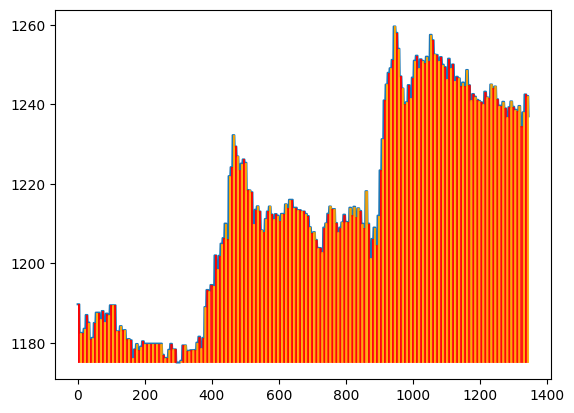

In [28]:
#plt.plot(back_test.log["action"])
X = range(len(back_test.log["closing_price"]))
y_mn = min(back_test.log["closing_price"])
plt.plot(X,back_test.log["closing_price"])

for i,action in enumerate(back_test.log["action"]):
    if action == BUY_ACTION:
        plt.plot([i,i],[y_mn,back_test.log["closing_price"][i]], c = "red",linewidth = .5)
    elif action == SELL_ACTION:
        plt.plot([i,i],[y_mn,back_test.log["closing_price"][i]], c = "orange", linewidth = .5)

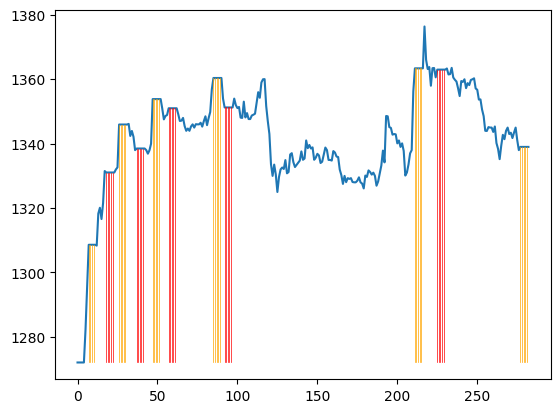

In [23]:
#plt.plot(back_test.log["action"])
X = range(len(back_test.log["closing_price"]))
y_mn = min(back_test.log["closing_price"])
plt.plot(X,back_test.log["closing_price"])

for i,action in enumerate(back_test.log["action"]):
    if action == BUY_ACTION:
        plt.plot([i,i],[y_mn,back_test.log["closing_price"][i]], c = "red",linewidth = .5)
    elif action == SELL_ACTION:
        plt.plot([i,i],[y_mn,back_test.log["closing_price"][i]], c = "orange", linewidth = .5)

In [15]:
back_test.log["action"]

[1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [102]:
curr_agent.save("Rushi/models/agent_roll_1.pt")

In [10]:
trainer.storage["returns"].min()

KeyError: 'returns'

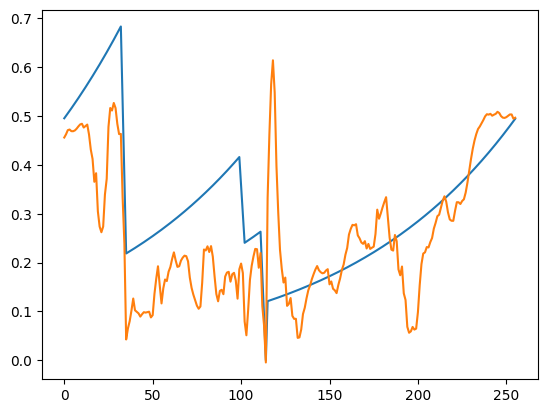

In [104]:
#plt.plot(trainer.storage["advantages"].cpu()[:,42])
plt.plot(trainer.storage["returns"].cpu()[:,42])
plt.plot(trainer.storage["values"].cpu()[:,42])
#plt.plot(trainer.storage["rewards"].cpu()[:,42])
#plt.plot(trainer.storage["dones"].cpu()[15,:])

In [ ]:
back_test.step_trade_counter

0

In [ ]:
back_test.log.keys()

dict_keys(['timestamp', 'money', 'is_trade_complete', 'stock_value', 'total_value', 'action', 'state_length', 'current_pointer', 'step_trade_counter'])

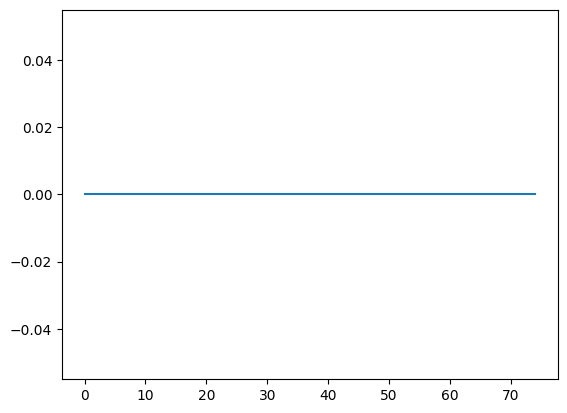

In [ ]:
plt.plot(back_test.log["action"][:100])

In [ ]:
len(back_test.log["action"])

1001

In [ ]:
agent.save(path= "Rushi/models/agent1.pt")

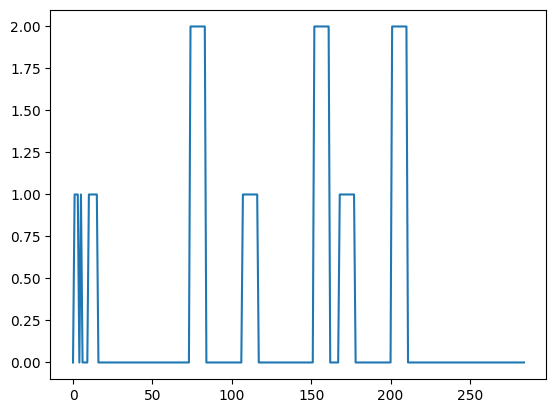

In [ ]:
plt.plot(back_test.log["action"])

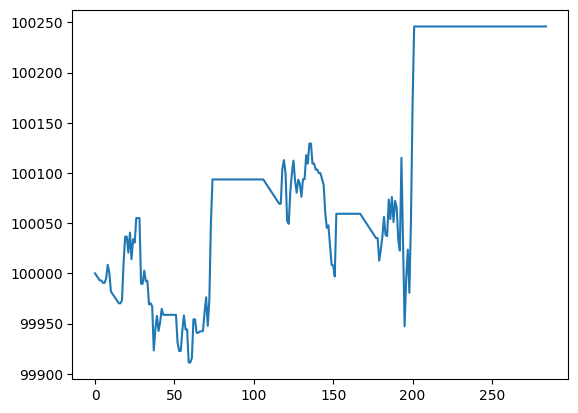

In [ ]:
back_test.plotValue()

In [ ]:
back_test.log["action"][-1]

1

In [ ]:
close = makeFeatures(df= df,mode= "5minute")["close"]
df_close = df.close.values

In [ ]:
len(close), len(df_close)

(3521, 5000)

In [ ]:
start_index = len(df_close) - len(close)

In [ ]:
df_close[start_index]

1272.5

In [ ]:
close[0]

1272.5